# Data exploration and preprocessing

## Project Motivation 

After a stroke, many patients are left with damaging lesions in their brains. Effects of this damage range from lateralized neuropathy to cognitive deficits. MRI scans are frequently used in research context to examine the location and extent of lesions by tracing on to the brain to produce *lesion masks*. 

These masks have been previously used to localize and predict movement effects of stroke, but predicting cogitive impacts has ben more challenging. To begin addressing this issue, we have worked to develop a pipeline to import, process, and combine MRI images and lesion masks in preparation for analysis with convolutional neural networks (a basic version of which is presented here). 

### Get all dem libraries

In [31]:
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from glob import glob
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

seed = 42
np.random.seed(seed)  # for reproducibility

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float32"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils

## Load T1 images

In [ ]:
label_df = pd.read_csv("/sdata/comppsych/lesion/phenotype_t1.csv")
data = []
labels = []
t1_files = glob('/sdata/comppsych/lesion/Hackathon_Lesion_Data/lesion_identification_training_set/*/*_warped.nii.gz')
t1_mni = dict()

for file in t1_files:
    match = re.match(r'.*([0-9]{4}).*', file)[1]
    t1_mni[str(match)] = file

for sample in label_df.ID:
    file = t1_mni[str(sample)]
    t1_img = nib.load(file)
    t1_data = t1_img.get_data()
    data.append(t1_data)

labels_t1  = np.array(label_df)

In [ ]:
# np.save("/sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_np_array", data_t1)
# np.save("/sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_labels", labels_t1)

## Data preprocessing

In [ ]:
data_t1 = np.load("/Dedicated/jmichaelson-sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_np_array.npy")
lables_t1 = np.load("/Dedicated/jmichaelson-sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_labels.npy")

(81, 182, 218, 182)


<IPython.core.display.Javascript object>


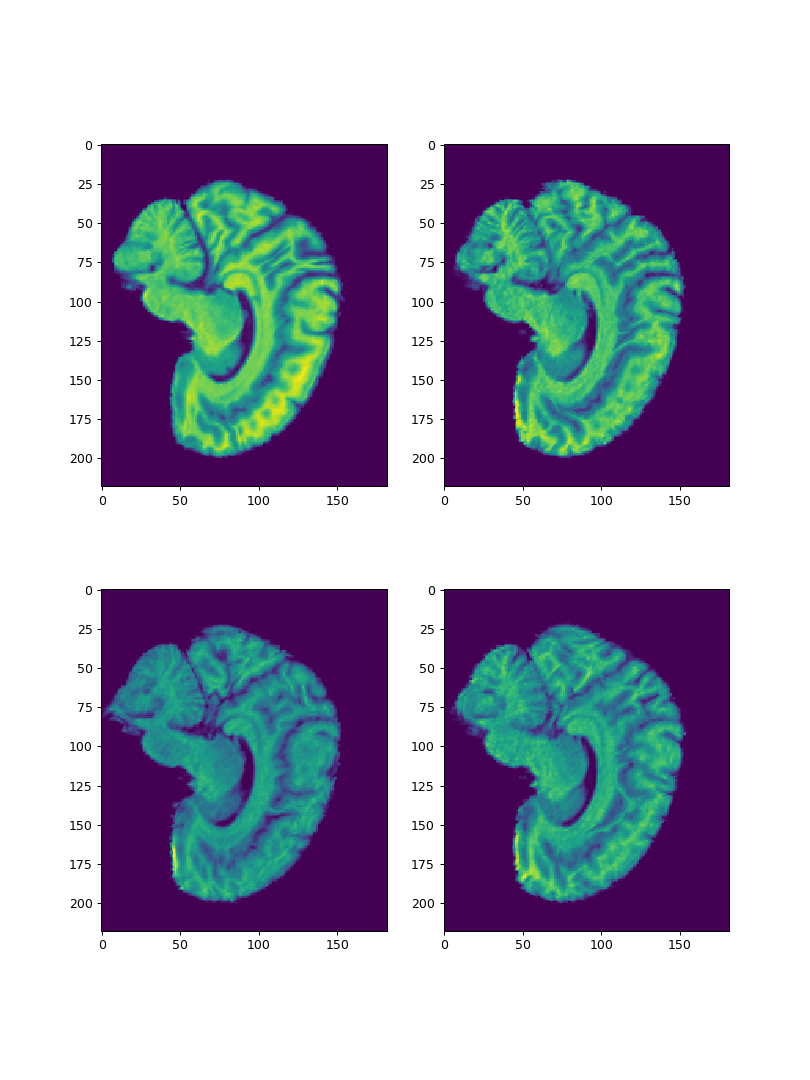

In [32]:
%matplotlib notebook
print(data_t1.shape)

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 9
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(data_t1[2*i,80,:,:])

In [28]:
from skimage import data, img_as_float
from skimage import exposure

data_t1_hnorm = np.zeros(data_t1.shape)
for i in range(0, len(data_t1)):
    data_t1_hnorm[i] = exposure.equalize_hist(data_t1[i,:,:,:])
    
#data_t1_anorm = np.zeros(data_t1.shape)
#for i in range(0, len(data_t1)):
#    data_t1_anorm[i] = exposure.equalize_adapthist(data_t1[i,:,:,:], clip_limit = 0.03)
    
data_t1_rescale = np.zeros(data_t1.shape)
for i in range(0, len(data_t1)):
    img = data_t1[i,:,:,:]
    p2, p98 = np.percentile(img, (2, 98))
    data_t1_rescale[i] = exposure.rescale_intensity(img, in_range=(p2, p98))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


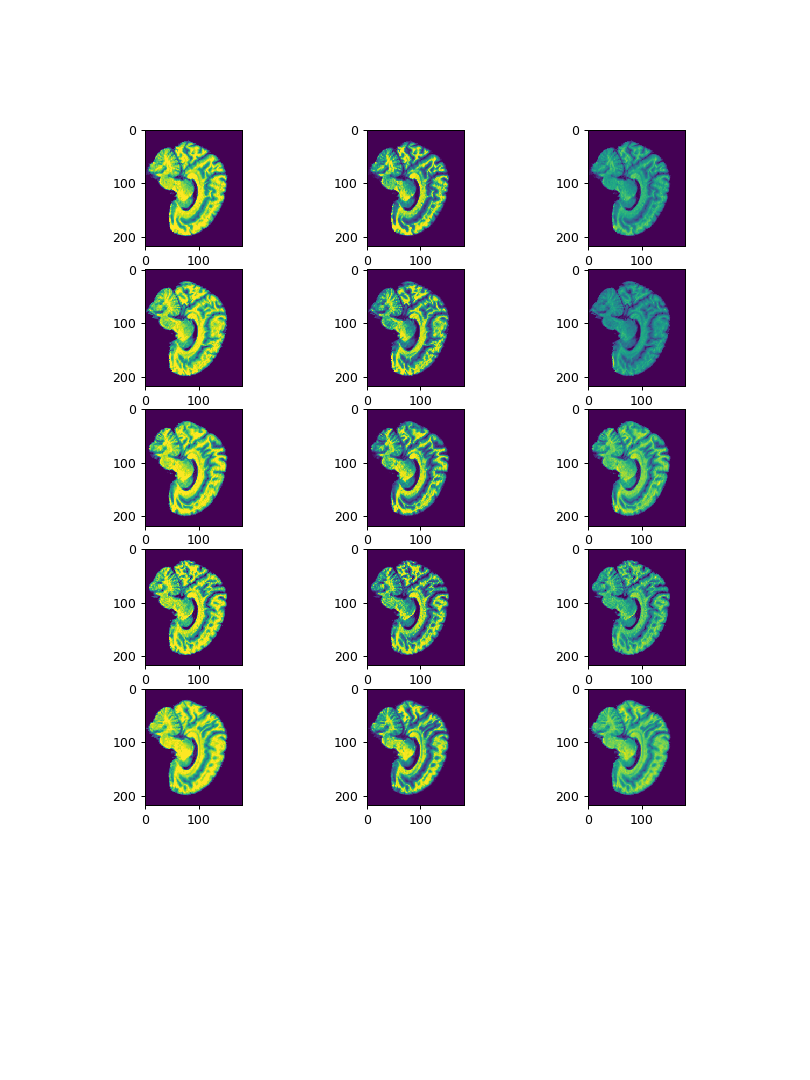

In [33]:
%matplotlib notebook
for i in range(3, 18, 3):
    plt.subplot(6, 3, i-2)
    plt.imshow(data_t1_rescale[i,80,:,:])
    plt.subplot(6, 3, i-1)
    plt.imshow(data_t1_hnorm[i,80,:,:])
    plt.subplot(6, 3, i)
    plt.imshow(data_t1[i,80,:,:])

In [ ]:
# np.save("/sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_hnorm", data_t1_hnorm)

## Lesion masks

In [ ]:
data = []
labels = []
lesion_masks = glob('/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/All_subs_405_Lesion_Masks/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*/([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    labels.append(df.loc[sub_id]['Score'])
    les_img = nib.load(les_file)
    les_data = les_img.get_data()
    data.append(les_data)
#     les_data_1d = les_data.reshape(np.prod(les_data.shape))
#     data_collector[sub_id] = les_data #les_data_1d

In [ ]:
data_array = np.array(data, dtype="float")
labels_array = np.array(labels, dtype="float")
print "Data shape: ", data_array.shape
print "Label shape: ", labels_array.shape

#### Flatten the array for vecotirzed approach

In [22]:
data_array_flattened = data_array_mask.reshape((data_array_mask.shape[0], -1))
print "Flattened data shape: ", data_array_flattened.shape

Flattened data shape:  (405, 7221032)


#### Reduce dimensionality by deleting all 0 columns

In [23]:
data_array_flattened_reduced = data_array_flattened[:,~np.all(data_array_flattened == 0, axis=0)]
print "Reduced dimensionality by ", data_array_flattened.shape[1] - data_array_flattened_reduced.shape[1]
print "Now contains ", data_array_flattened_reduced.shape[1], " features"

Reduced dimensionality by  5580174
Now contains  1640858  features


### Load for CNN

In [17]:
data_array_mask = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array.npy")
labels_array_mask = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")

### Load for NN

In [19]:
data_array_flattened = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened.npy")
labels_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")
data_array_flattened_reduced = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened_reduced.npy")

### Explore

<IPython.core.display.Javascript object>


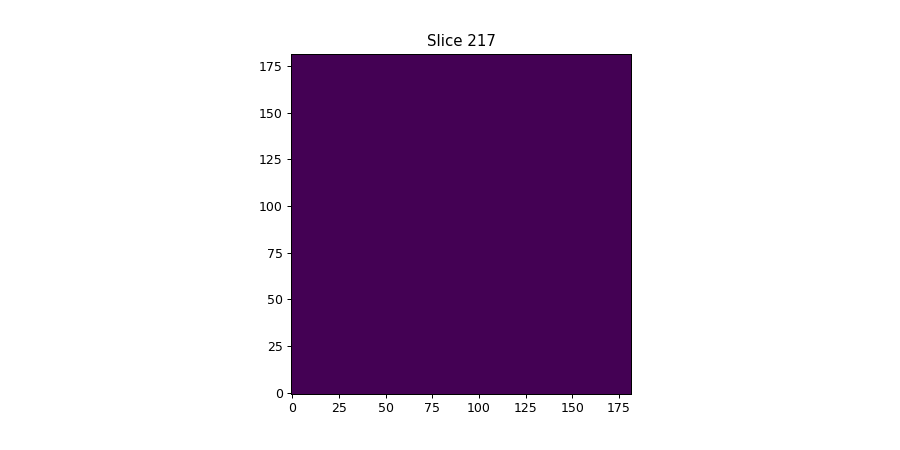

In [37]:
%matplotlib notebook
fig = plt.figure("Lesion mask", figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

image = data_array_mask[0,:,:,:]
for s in range(218):
    ax1.cla()
    ax1.set_title("Slice {}".format(s))
    ax1.imshow(image[:,s,:], origin="lower")


    fig.canvas.draw()

<IPython.core.display.Javascript object>


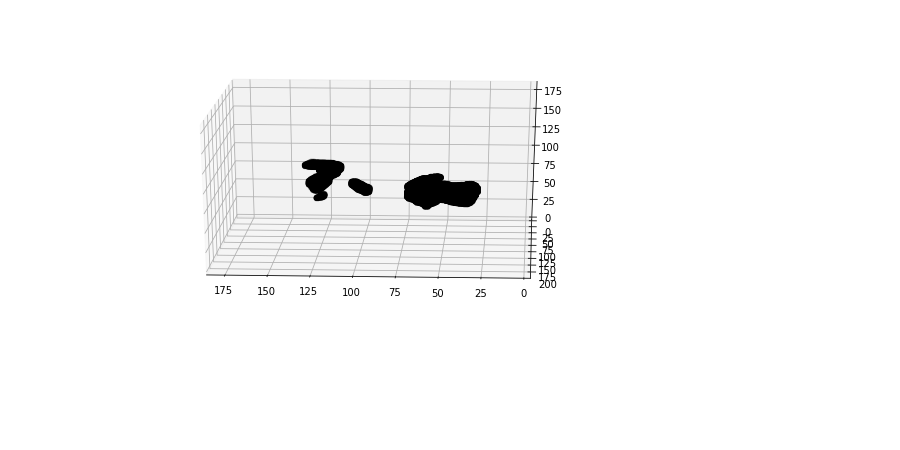

In [ ]:
%matplotlib notebook
pos = np.where(image==1)
fig = plt.figure("Lesion mask 3D", figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for angle in range(120):
    ax.cla()
    ax.view_init(20, angle)
    ax.scatter(pos[0], pos[1], pos[2], c='black')
    ax.set_xlim3d(0, 182)
    ax.set_ylim3d(0, 218)
    ax.set_zlim3d(0, 182)
    fig.canvas.draw()

### Sum all the lesion masks to get an idea of the coverage and to find hotspots

In [39]:
all_masks = data_array_mask.sum(axis=0)
all_masks.shape

(182, 218, 182)

<IPython.core.display.Javascript object>


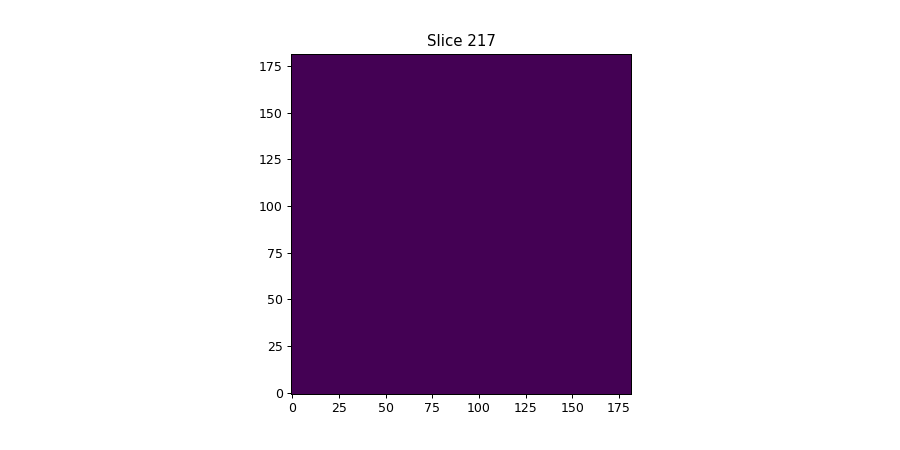

In [40]:
%matplotlib notebook
fig = plt.figure("Lesion mask", figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

for s in range(218):
    ax1.cla()
    ax1.set_title("Slice {}".format(s))
    ax1.imshow(all_masks[:,s,:], origin="lower")


    fig.canvas.draw()

<IPython.core.display.Javascript object>


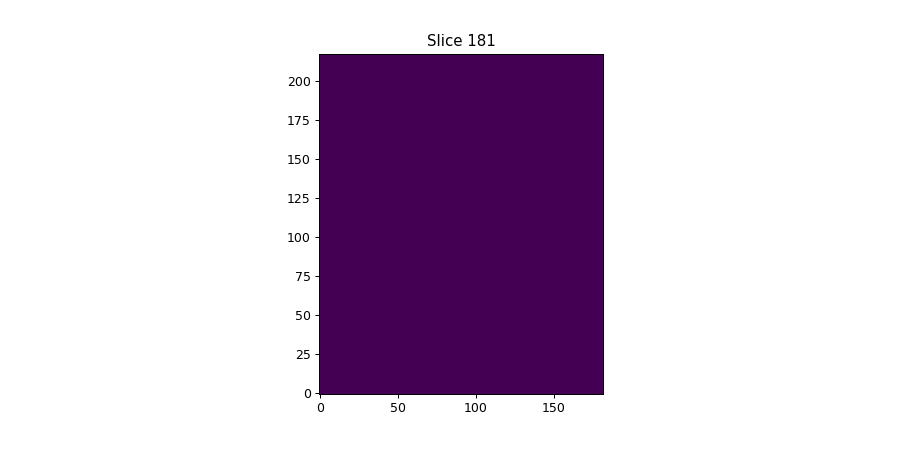

In [41]:
%matplotlib notebook
fig = plt.figure("Lesion mask", figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

for s in range(182):
    ax1.cla()
    ax1.set_title("Slice {}".format(s))
    ax1.imshow(all_masks[s,:,:], origin="lower")


    fig.canvas.draw()

<IPython.core.display.Javascript object>


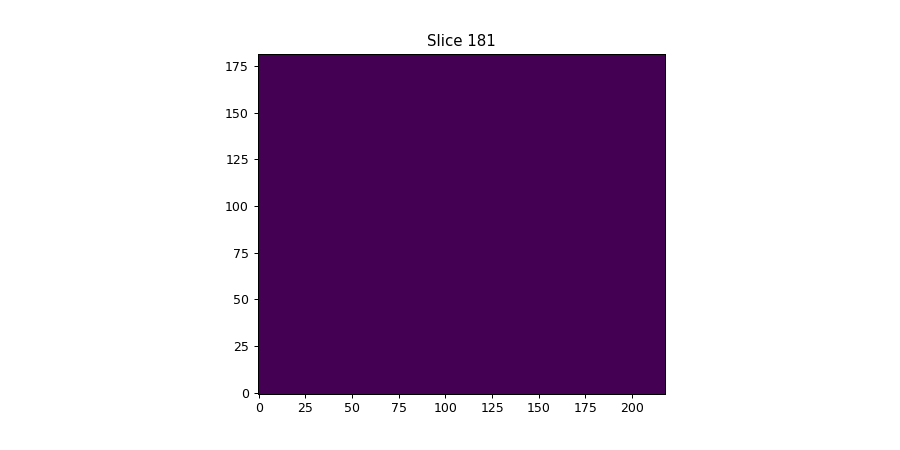

In [43]:
%matplotlib notebook
fig = plt.figure("Lesion mask", figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

for s in range(182):
    ax1.cla()
    ax1.set_title("Slice {}".format(s))
    ax1.imshow(all_masks[:,:,s], origin="lower")


    fig.canvas.draw()

## The labels

In [16]:
label_df = pd.read_csv("/Dedicated/jmichaelson-sdata/comppsych/lesion/phenotype_405.csv")
label_df

,ID,Gc_bi_all_subs_405,Gc_all_subs_405,Gl_all_subs_405,Gl_bi_all_subs_405,Gs_all_subs_405,Gs_bi_all_subs_405,Gv_all_subs_405,Gv_bi_all_subs_405,Gwm_all_subs_405,Gwm_bi_all_subs_405,g_bi_all_subs_405,g_hi_all_subs_405
0,194,0.280165,-0.425845,-0.972046,-0.924240,-0.818462,-0.596712,-0.013080,0.928886,-0.783726,-0.516991,-0.672247,-0.698339
1,297,0.390203,0.285491,-1.999740,-2.520697,0.215225,0.323129,0.230828,-0.075928,0.449694,0.662667,0.284658,0.285341
2,318,0.555099,2.083843,0.704475,-0.277461,1.674966,0.004435,2.099044,0.501042,1.981132,-0.005991,2.212497,2.098086
3,376,-0.412211,-1.317183,-0.308457,0.498059,-1.299558,0.072503,-1.722894,-0.866534,-1.451246,-0.069463,-1.538743,-1.526178
4,414,-1.209015,-1.240517,-0.479600,-0.556820,-0.597491,-0.169685,-0.422785,0.204322,-0.486857,0.144966,-0.661666,-0.708529
5,468,0.943766,1.100817,-0.582900,-0.895843,0.291387,-0.544236,1.045307,0.866347,0.738626,-0.079611,0.728580,0.782374
6,500,-0.377269,0.624045,-0.934794,-1.674852,0.245556,-0.098610,-0.045300,-1.021389,1.323458,1.314497,0.974868,0.847392
7,513,-0.734567,-2.081386,-2.516591,-1.699193,-1.078296,0.480664,-0.995585,0.209477,-1.529889,-0.153968,-1.828077,-1.711982
8,571,-1.421442,-0.559533,0.834696,0.800926,1.549833,1.041738,0.698749,0.498936,0.078731,-0.127824,0.345916,0.326303
9,615,0.200815,-0.553417,-0.323284,-0.474592,-0.930682,-0.845479,-0.436661,0.477143,-0.750650,0.151976,-0.777013,-0.754159


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b088d9d09d0>]],
      dtype=object)

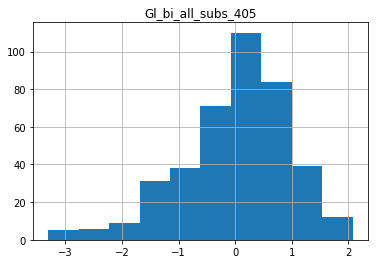

In [45]:
%matplotlib inline

label_df.hist(column ="Gl_bi_all_subs_405")

<IPython.core.display.Javascript object>


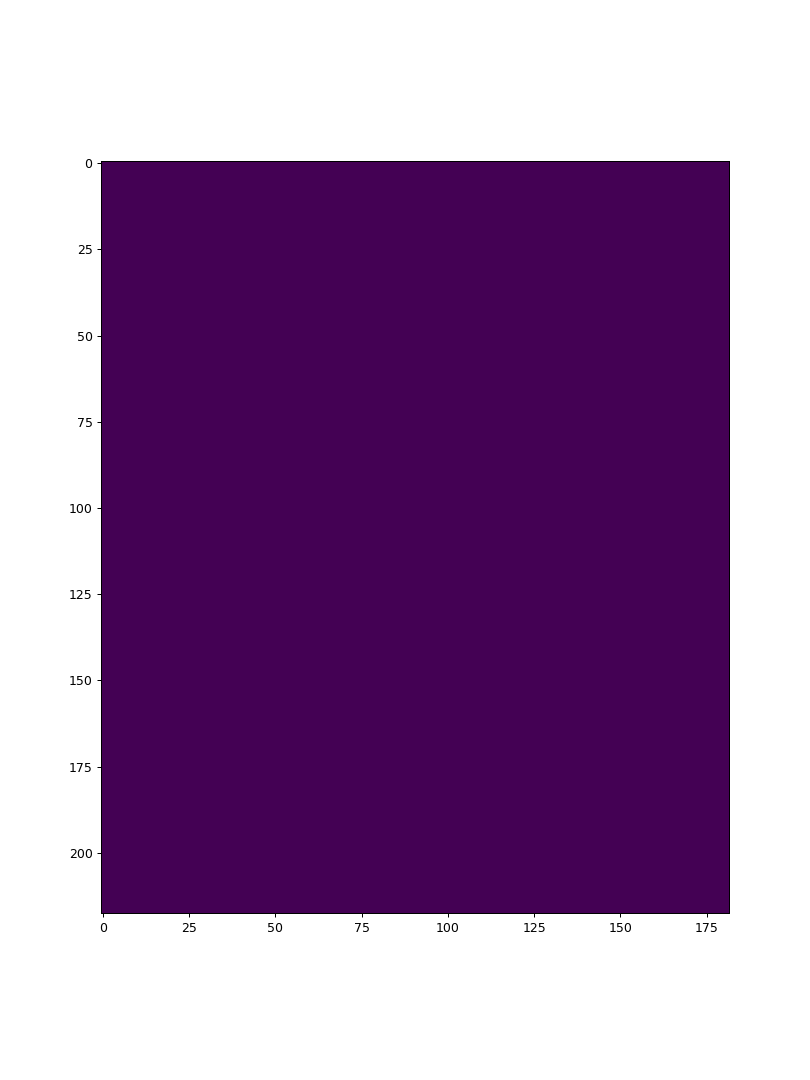

In [51]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(182):
    im = plt.imshow(all_masks[i,:,:], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()